In [1]:
!git clone https://github.com/dayeonki/askqe

Cloning into 'askqe'...
remote: Enumerating objects: 1119, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 1119 (delta 14), reused 5 (delta 5), pack-reused 1102 (from 2)
Receiving objects: 100% (1119/1119), 52.45 MiB | 10.14 MiB/s, done.
Resolving deltas: 100% (886/886), done.
Updating files: 100% (1037/1037), done.


In [2]:
!pip install -q vllm
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.6/192.6 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 147.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 122.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.

In [1]:
import sys
REPO_PATH = "askqe"

sys.path.insert(0, REPO_PATH)
sys.path.insert(0, f"{REPO_PATH}/QG/code")
sys.path.insert(0, f"{REPO_PATH}/QA/code")
sys.path.insert(0, f"{REPO_PATH}/biomqm/askqe")
sys.path.insert(0, f"{REPO_PATH}/evaluation/string-comparison")

In [2]:
import os
os.environ["VLLM_WORKER_MULTIPROC_METHOD"] = "spawn"

In [3]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

#Loading data

In [4]:
from QG.code.prompt import nli as qg_prompt_template
from QA.code.prompt import qa_prompt as qa_prompt_template
from biomqm.askqe.prompt import atomic_fact_prompt as atomic_fact_prompt_template

In [5]:
import json
import os
import glob

LIMIT = None # change to minimize data or None


def calculate_mqm_score(errors):
    weights = {"No error": 0, "Neutral": 0, "Minor": 1, "Major": 5, "Critical": 25}
    score_penalty = 0
    for error in errors:
        severity = error.get("severity")
        score_penalty += weights.get(severity, 0)
    return max(0, 100 - score_penalty)

def get_max_severity(errors):
    if not errors:
        return "No Error"
    severities = [e.get("severity") for e in errors]
    if "Critical" in severities:
        return "Critical"
    if "Major" in severities:
        return "Major"
    return "Minor"

def load_biomqm_data(file_path, limit=None):
    data_entries = []
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                if limit and i >= limit:
                    break
                item = json.loads(line)

                # BIOMQM structure: src, tgt, bt_tgt, errors_tgt
                entry = {
                    'id': item.get('doc_id', f'doc_{i}'),
                    'source': item['src'],
                    'target': item['tgt'],
                    'backtranslation': item.get('bt_tgt', ''),
                    'errors': item.get('errors_tgt', []),
                    'mqm_score': calculate_mqm_score(item.get('errors_tgt', [])),
                    'severity': get_max_severity(item.get('errors_tgt', []))
                }
                data_entries.append(entry)

        print(f"Loaded {len(data_entries)} entries from BIOMQM successfully.")
        return data_entries
    except FileNotFoundError:
        print(f"Error: File {file_path} not found.")
        return []


BIOMQM_FILE = f"{REPO_PATH}/biomqm/dev_with_backtranslation.jsonl"
dataset = load_biomqm_data(BIOMQM_FILE, limit=LIMIT)


Loaded 5216 entries from BIOMQM successfully.


#Cleaning data

In [6]:
import pandas as pd

def term_in_data(df):
    valid_rows = []

    for row in df:
        tgt = row.get('target', '')
        src = row.get('source', '')
        errors = row.get('errors', [])
        is_row_clean = True

        for error in errors:
            term = error.get('term', '')

            if term:
                if term not in tgt and term not in src:
                    is_row_clean = False
                    break

        if is_row_clean:
            valid_rows.append(row)

    return valid_rows


print("SHAPE BEFORE:", len(dataset))
dataset_clean = term_in_data(dataset)
print("SHAPE AFTER:", len(dataset_clean))

SHAPE BEFORE: 5216
SHAPE AFTER: 5000


#Model init

In [7]:
from vllm import LLM, SamplingParams

MODEL_ID = "Qwen/Qwen2.5-14B-Instruct-AWQ"

# QWEN
#"Qwen/Qwen2.5-3B-Instruct-AWQ"
#"Qwen/Qwen2.5-7B-Instruct-AWQ"
#"Qwen/Qwen2.5-14B-Instruct-AWQ"
#"Qwen/Qwen3-4B-Instruct-2507" +
#"cyankiwi/Qwen3-30B-A3B-Instruct-2507-AWQ-4bit"


# Llama
#"meta-llama/Meta-Llama-3-8B-Instruct"

# Gemma
#"casperhansen/gemma-7b-it-awq"
#"google/gemma-2-9b-it"
#"solidrust/gemma-2-9b-it-AWQ"

# Yi
#"01-ai/Yi-1.5-9B"
#"01-ai/Yi-1.5-6B"

# Mistral
#casperhansen/mistral-nemo-instruct-2407-awq

llm = LLM(
    model=MODEL_ID,
    dtype="half",
    max_model_len=2048,
    gpu_memory_utilization=0.60,
    #quantization="awq",
    seed=0,
    enable_prefix_caching=True,
    disable_log_stats=True,
    # enforce_eager=False,
)

INFO 02-11 17:27:55 [utils.py:261] non-default args: {'dtype': 'half', 'max_model_len': 2048, 'enable_prefix_caching': True, 'gpu_memory_utilization': 0.6, 'disable_log_stats': True, 'model': 'Qwen/Qwen2.5-14B-Instruct-AWQ'}


config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

INFO 02-11 17:28:14 [model.py:541] Resolved architecture: Qwen2ForCausalLM
INFO 02-11 17:28:14 [model.py:1561] Using max model len 2048
INFO 02-11 17:28:14 [awq_marlin.py:162] The model is convertible to awq_marlin during runtime. Using awq_marlin kernel.
INFO 02-11 17:28:14 [scheduler.py:226] Chunked prefill is enabled with max_num_batched_tokens=8192.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Parse safetensors files:   0%|          | 0/3 [00:00<?, ?it/s]

INFO 02-11 17:28:16 [vllm.py:624] Asynchronous scheduling is enabled.


generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

INFO 02-11 17:30:47 [llm.py:343] Supported tasks: ['generate']


In [8]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)

SAMPLING_PARAMS = SamplingParams(
    temperature=0,
    max_tokens=1024
)


def generate_text_batch(prompts, sampling_params=SAMPLING_PARAMS):
    formatted_prompts = []
    for p in prompts:
        messages = [{"role": "user", "content": p}]
        formatted = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        formatted_prompts.append(formatted)

    outputs = llm.generate(formatted_prompts, sampling_params)

    generated_texts = []
    for output in outputs:
        text = output.outputs[0].text.strip()
        if not text.endswith("]"):
            text = text + "]"
        if not text.startswith("["):
            text = "[" + text
        generated_texts.append(text)

    return generated_texts

def parse_list_output(text):
    """Parses a string representation of a list into a Python list."""
    import ast
    try:
        start = text.find('[')
        end = text.rfind(']') + 1
        if start != -1 and end != -1:
            candidate = text[start:end]
            return ast.literal_eval(candidate)
        return []
    except:
        return []


#AskQE pipeline

In [9]:
from transformers import pipeline
import numpy as np


N = len(dataset)

all_facts = [[] for _ in range(N)]
all_questions = [[] for _ in range(N)]
all_answers_src = [[] for _ in range(N)]
all_answers_bt = [[] for _ in range(N)]

print(f"Using cleaned data with shape = {len(dataset_clean)}")

# =============================================================================
# PHASE 1: Atomic Fact Extraction
# =============================================================================
print("\n" + "=" * 60)
print("PHASE 1: Atomic Fact Extraction")
print("=" * 60)

prompts_facts = [
    atomic_fact_prompt_template.replace("{{sentence}}", e["source"])
    for e in dataset_clean
]

facts_str_list = generate_text_batch(prompts_facts, SAMPLING_PARAMS)
raw_all_facts = [parse_list_output(s) for s in facts_str_list]
print(f"Facts extracted: {sum(len(f) for f in raw_all_facts)} total facts")
num_empty = raw_all_facts.count([])
print(f"Number of empty fact lists: {num_empty}")


# =============================================================================
# PHASE 1.5: Entailment Filtering
# =============================================================================
print("\n" + "=" * 60)
print("PHASE 1.5: NLI Entailment Filtering")
print("=" * 60)

NLI_MODEL_ID = "potsawee/deberta-v3-large-mnli"

nli_pipeline = pipeline(
    "text-classification",
    model=NLI_MODEL_ID,
    device=device
)

flat_nli_inputs = []
for idx, facts in enumerate(raw_all_facts):
    if not facts:
        continue
    source = dataset_clean[idx]["source"]
    for fact in facts:
        flat_nli_inputs.append((idx, fact, [source, fact]))

print(f"Running NLI on {len(flat_nli_inputs)} fact-source pairs...")
nli_pairs = [{"text": t[2][0], "text_pair": t[2][1]} for t in flat_nli_inputs]
nli_results = nli_pipeline(nli_pairs, batch_size=64, truncation=True, max_length=512)

kept = 0
for (idx, fact, sfp), res in zip(flat_nli_inputs, nli_results):
    label = res["label"].upper()
    score = res["score"]
    if ("LABEL_1" not in label) or ("LABEL_1" in label and score < 0.85):
        all_facts[idx].append(fact)
        kept += 1

removed = sum(len(f) for f in raw_all_facts) - kept
print(f"NLI Complete: {kept} facts retained (filtered {removed} contradictions)")
num_empty = all_facts.count([])
print(f"Number of empty fact lists: {num_empty}")


# =============================================================================
# PHASE 2: Question Generation
# =============================================================================
print("\n" + "=" * 60)
print("PHASE 2: Question Generation")
print("=" * 60)

jobs = []
for idx, facts in enumerate(all_facts):
    if facts:
        prompt = qg_prompt_template.replace("{{sentence}}", dataset_clean[idx]["source"]).replace("{{atomic_facts}}", str(facts))
        jobs.append({"idx": idx, "prompt": prompt})

prompts = [j["prompt"] for j in jobs]
results = generate_text_batch(prompts, SAMPLING_PARAMS)

for job, result in zip(jobs, results):
    all_questions[job["idx"]] = parse_list_output(result)

print(f"Questions generated: {sum(len(q) for q in all_questions)} total")
print(f"Number of empty question lists: {all_questions.count([])}")


# =============================================================================
# PHASE 3 & 4: QA on Source & Backtranslation
# =============================================================================
print("\n" + "=" * 60)
print("PHASE 3 & 4: Question Answering (src + BT)")
print("=" * 60)

prompts_qa_src = []
prompts_qa_bt = []
qa_idx_map = []

for idx, questions in enumerate(all_questions):
    if not questions:
        continue

    # scr prompt
    p_src = (
        qa_prompt_template
        .replace("{{sentence}}", dataset_clean[idx]["source"])
        .replace("{{questions}}", str(questions))
    )
    prompts_qa_src.append(p_src)

    # BT prompt
    p_bt = (
        qa_prompt_template
        .replace("{{sentence}}", dataset_clean[idx].get("backtranslation", ""))
        .replace("{{questions}}", str(questions))
    )
    prompts_qa_bt.append(p_bt)

    qa_idx_map.append(idx)

combined_prompts = prompts_qa_src + prompts_qa_bt
all_answers = generate_text_batch(combined_prompts, SAMPLING_PARAMS)

split_idx = len(prompts_qa_src)
answers_src = all_answers[:split_idx]
answers_bt = all_answers[split_idx:]

for prompt_pos, dataset_idx in enumerate(qa_idx_map):
    curr_questions = all_questions[dataset_idx]

    src_ans = parse_list_output(answers_src[prompt_pos])
    bt_ans = parse_list_output(answers_bt[prompt_pos])

    if len(src_ans) != len(curr_questions) or len(bt_ans) != len(curr_questions):
        src_ans = []
        bt_ans = []

    src_ans = src_ans[:len(curr_questions)]
    bt_ans = bt_ans[:len(curr_questions)]

    all_answers_src[dataset_idx] = src_ans
    all_answers_bt[dataset_idx] = bt_ans

print(f"QA Complete: {sum(len(a) for a in all_answers_src)} source answers, "
      f"{sum(len(a) for a in all_answers_bt)} BT answers")
print(f"Number of empty answers lists (SRC): {all_answers_src.count([])}")
print(f"Number of empty answers lists (BT): {all_answers_bt.count([])}")


# =============================================================================
# FINAL: Build Results List
# =============================================================================
print("\n" + "=" * 60)
print("FINAL: Building Results")
print("=" * 60)

results = []
for idx, entry in enumerate(dataset_clean):
    results.append({
        "id": entry["id"],
        "source": entry["source"],
        "backtranslation": entry.get("backtranslation", ""),
        "facts": all_facts[idx],
        "questions": all_questions[idx],
        "answers_src": all_answers_src[idx],
        "answers_bt": all_answers_bt[idx],
        "mqm_score": entry.get("mqm_score", None),
        "severity": entry.get("severity", None),
    })


print("\nPipeline execution complete.")

output_file = "askqe_data.jsonl"
with open(output_file, 'w') as f:
    for res in results:
        f.write(json.dumps(res) + '\n')

print(f"Results saved to {output_file}")

Using cleaned data with shape = 5000

PHASE 1: Atomic Fact Extraction


Adding requests:   0%|          | 0/5000 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/5000 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

Facts extracted: 15141 total facts
Number of empty fact lists: 109

PHASE 1.5: NLI Entailment Filtering


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Device set to use cuda


Running NLI on 15141 fact-source pairs...
NLI Complete: 11262 facts retained (filtered 3879 contradictions)
Number of empty fact lists: 651

PHASE 2: Question Generation


Adding requests:   0%|          | 0/4565 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/4565 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

Questions generated: 11896 total
Number of empty question lists: 651

PHASE 3 & 4: Question Answering (src + BT)


Adding requests:   0%|          | 0/9130 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/9130 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

QA Complete: 11742 source answers, 11742 BT answers
Number of empty answers lists (SRC): 719
Number of empty answers lists (BT): 719

FINAL: Building Results

Pipeline execution complete.
Results saved to askqe_data.jsonl


#Scoring & Evaluation

In [10]:
import json
import torch

from utils import (
    f1_score as repo_f1_score,
    exact_match_score as repo_exact_match_score,
    chrf_score as repo_chrf_score,
    bleu_score as repo_bleu_score,
    compare_answers as repo_compare_answers,
    normalize_answer
)

device = "cuda" if torch.cuda.is_available() else "cpu"

output_file = "askqe_data.jsonl"

results = []
lost_cnt = 0
with open(output_file, "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        data = json.loads(line)
        if data.get("answers_src") and data.get("answers_bt"):
            results.append(data)
        else:
            lost_cnt += 1

print(f"Loaded {len(results)} out of {len(results) + lost_cnt} records from {output_file}")
print("First element example:", results[0] if results else "empty list")

Loaded 4497 out of 5000 records from askqe_data.jsonl
First element example: {'id': 'doc11', 'source': 'Three cases of cervicofacial NF are presented in this case report.', 'backtranslation': 'This case report presents three cases of cervicofacial NF.', 'facts': ['Three cases of cervicofacial NF are presented.'], 'questions': ['How many cases of cervicofacial NF are presented in this case report?', 'What is the focus of this case report?'], 'answers_src': ['Three', 'Cases of cervicofacial NF'], 'answers_bt': ['Three', 'Three cases of cervicofacial NF'], 'mqm_score': 95, 'severity': 'Major'}


## ASKQE scores using different metrics evaluated on BIOMQM per error severity

In [11]:
import numpy as np
from collections import Counter
from sacrebleu import sentence_bleu, sentence_chrf
from sentence_transformers import SentenceTransformer, util
import json

sbert_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
print("Calculating Scores...")

all_src_answers = []
all_bt_answers = []
indices_map = []

for i, res in enumerate(results):

    src_list = res.get('answers_src', [])
    bt_list = res.get('answers_bt', [])

    if src_list and bt_list:
        src_str_list = [str(x) for x in src_list]
        bt_str_list = [str(x) for x in bt_list]

        all_src_answers.extend(src_str_list)
        all_bt_answers.extend(bt_str_list)

        indices_map.append((i, len(src_list)))

        f1_vals = []
        em_vals = []
        bleu_vals = []
        chrf_vals = []

        for p, g in zip(src_str_list, bt_str_list):
            f1_vals.append(repo_f1_score(p, g, normalize=True))
            em_vals.append(int(repo_exact_match_score(p, g, normalize=True)))
            bleu_vals.append(sentence_bleu(p, [g]).score)
            chrf_vals.append(sentence_chrf(p, [g]).score)

        results[i]['askqe_f1'] = np.mean(f1_vals)
        results[i]['askqe_em'] = np.mean(em_vals)
        results[i]['askqe_bleu'] = np.mean(bleu_vals)
        results[i]['askqe_chrf'] = np.mean(chrf_vals)

    else:
        indices_map.append((i, 0))
        results[i]['askqe_f1'] = 0.0
        results[i]['askqe_em'] = 0.0
        results[i]['askqe_bleu'] = 0.0
        results[i]['askqe_chrf'] = 0.0
        results[i]['askqe_sbert'] = 0.0

print(f"Encoding {len(all_src_answers)} answer pairs simultaneously...")

embeddings_src = sbert_model.encode(all_src_answers, batch_size=64, convert_to_tensor=True)
embeddings_bt = sbert_model.encode(all_bt_answers, batch_size=64, convert_to_tensor=True)

cursor = 0
for idx, count in indices_map:
    if count > 0:
        doc_scores = []
        for k in range(count):
            sim = util.cos_sim(embeddings_src[cursor + k], embeddings_bt[cursor + k]).item()
            doc_scores.append(sim)

        results[idx]['askqe_sbert'] = np.mean(doc_scores)
        cursor += count
    else:
        if 'askqe_sbert' not in results[idx]:
             results[idx]['askqe_sbert'] = 0.0

print("Scoring complete")

output_file = "askqe_results.jsonl"
with open(output_file, 'w') as f:
    for res in results:
        f.write(json.dumps(res) + '\n')

print(f"Results saved to {output_file}")

Calculating Scores...
Encoding 11742 answer pairs simultaneously...
Scoring complete
Results saved to askqe_results.jsonl


Severity   F1     EM     CHRF   BLEU   SBERT 
No Error   0.823  0.581  84.25   71.12   0.925
Minor      0.774  0.494  81.09   64.95   0.894
Major      0.765  0.548  79.81   66.97   0.874
Critical   0.744  0.539  77.52   66.28   0.856


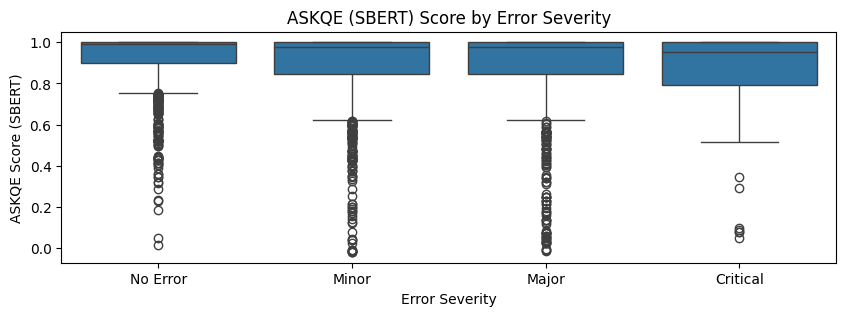

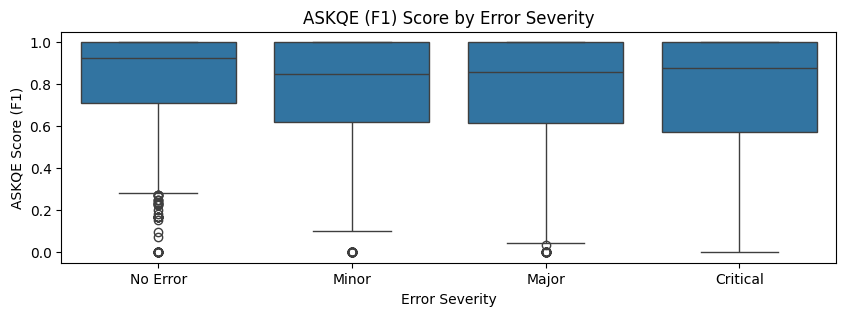

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

categories = ["No Error", "Minor", "Major", "Critical"]
print(f"{'Severity':<10} {'F1':<6} {'EM':<6} {'CHRF':<6} {'BLEU':<6} {'SBERT':<6}")

for cat in categories:

    group = [r for r in results if r.get('severity') == cat]
    if not group:
        continue

    avg_f1    = np.mean([r.get('askqe_f1', 0) for r in group])
    avg_em    = np.mean([r.get('askqe_em', 0) for r in group])
    avg_chrf  = np.mean([r.get('askqe_chrf', 0) for r in group])
    avg_bleu  = np.mean([r.get('askqe_bleu', 0) for r in group])
    avg_sbert = np.mean([r.get('askqe_sbert', 0) for r in group])

    print(f"{cat:<10} {avg_f1:.3f}  {avg_em:.3f}  {avg_chrf:.2f}   {avg_bleu:.2f}   {avg_sbert:.3f}")


# plot
plt.figure(figsize=(10, 3))

order = ["No Error", "Minor", "Major", "Critical"]

sns.boxplot(x='severity', y='askqe_sbert', data=pd.DataFrame(results), order=order)
plt.title('ASKQE (SBERT) Score by Error Severity')
plt.ylabel('ASKQE Score (SBERT)')
plt.xlabel('Error Severity')
plt.show()

plt.figure(figsize=(10, 3))
sns.boxplot(x='severity', y='askqe_f1', data=pd.DataFrame(results), order=order)
plt.title('ASKQE (F1) Score by Error Severity')
plt.ylabel('ASKQE Score (F1)')
plt.xlabel('Error Severity')
plt.show()


###Correlation analysis

In [13]:
import json

output_file = "askqe_results.jsonl"

results = []
with open(output_file, "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        results.append(json.loads(line))

print(f"Loaded {len(results)} records from {output_file}")
print("First element example:", results[0] if results else "empty list")

Loaded 4497 records from askqe_results.jsonl
First element example: {'id': 'doc11', 'source': 'Three cases of cervicofacial NF are presented in this case report.', 'backtranslation': 'This case report presents three cases of cervicofacial NF.', 'facts': ['Three cases of cervicofacial NF are presented.'], 'questions': ['How many cases of cervicofacial NF are presented in this case report?', 'What is the focus of this case report?'], 'answers_src': ['Three', 'Cases of cervicofacial NF'], 'answers_bt': ['Three', 'Three cases of cervicofacial NF'], 'mqm_score': 95, 'severity': 'Major', 'askqe_f1': 0.8333333333333333, 'askqe_em': 0.5, 'askqe_bleu': 73.15388580995516, 'askqe_chrf': 89.30677382155162, 'askqe_sbert': 0.9799196422100067}



Correlation Analysis (Kendall's Tau)
Expected: Strong POSITIVE correlation (Higher ASKQE score = Higher MQM score)
Metric     Tau        P-Value   
-----------------------------------
SBERT      0.0719     1.4163e-10
F1         0.0611     1.3147e-07
EM         0.0291     1.7908e-02
BLEU       0.0420     2.6031e-04
CHRF       0.0520     6.1531e-06
-----------------------------------


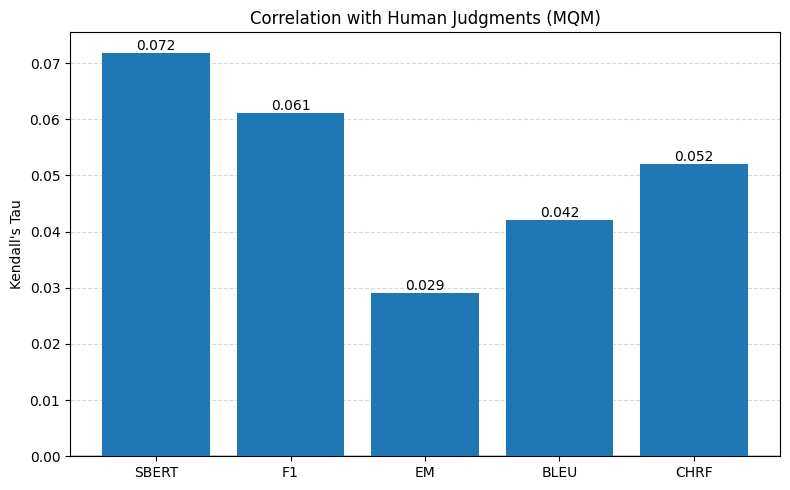

In [14]:
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt

df_results = pd.DataFrame(results)

print("\n" + "="*50)
print("Correlation Analysis (Kendall's Tau)")
print("Expected: Strong POSITIVE correlation (Higher ASKQE score = Higher MQM score)")
print("="*50)

metrics = {
    "SBERT": "askqe_sbert",
    "F1":    "askqe_f1",
    "EM":    "askqe_em",
    "BLEU":  "askqe_bleu",
    "CHRF":  "askqe_chrf"
}
names = []
values = []

print(f"{'Metric':<10} {'Tau':<10} {'P-Value':<10}")
print("-" * 35)

for name, col_name in metrics.items():
    tau, p_value = scipy.stats.kendalltau(df_results[col_name], df_results['mqm_score'], nan_policy='omit')
    names.append(name)
    values.append(tau)
    print(f"{name:<10} {tau:.4f}     {p_value:.4e}")

print("-" * 35)

# plot
plt.figure(figsize=(8, 5))
bars = plt.bar(names, values, zorder=3)

plt.grid(axis='y', linestyle='--', alpha=0.5, zorder=0)
plt.axhline(0, color='black', linewidth=1)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}',
             ha='center', va='bottom' if height > 0 else 'top', fontsize=10)

plt.ylabel("Kendall's Tau")
plt.title("Correlation with Human Judgments (MQM)")
plt.tight_layout()
plt.show()


##BT-Score

In [15]:
def save_checkpoint(data, filename):
    print(f"   [Checkpoint] Saving {len(data)} records to {filename}...")
    with open(filename, 'w', encoding='utf-8') as f:
        for item in data:
            f.write(json.dumps(item, ensure_ascii=False) + '\n')
    print("   [Checkpoint] Done.")

In [16]:
!pip install -q bert-score

In [17]:
from bert_score import score as bert_score
import pandas as pd
import scipy.stats

print("Calculating BT-Score...")

_, _, F1 = bert_score(
    [r['backtranslation'] for r in results],
    [r['source'] for r in results],
    lang="en",
    rescale_with_baseline=True,
    verbose=True
)

f1_values = F1.numpy()
for item, score in zip(results, f1_values):
    item['bt_score'] = float(score)

for r in results:
    if 'bt_score' not in r:
        print("WARNING. Some data is missing")
        r['bt_score'] = 0.0

df_results = pd.DataFrame(results)
tau, p_value = scipy.stats.kendalltau(df_results['bt_score'], df_results['mqm_score'])

print("\n" + "="*40)
print(f"{'Metric':<10} {'Tau':<10} {'P-Value':<10}")
print("-" * 40)
print(f"{'BT-Score':<10} {tau:.4f}     {p_value:.4e}")
print("="*40)

save_checkpoint(results, "askqe_results_final.jsonl")

Calculating BT-Score...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/47 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/71 [00:00<?, ?it/s]

done in 8.05 seconds, 558.96 sentences/sec

Metric     Tau        P-Value   
----------------------------------------
BT-Score   0.1017     1.4980e-20
   [Checkpoint] Saving 4497 records to askqe_results_final.jsonl...
   [Checkpoint] Done.


## xCOMET-QE

In [18]:
!pip install -q unbabel-comet

In [19]:
from comet import download_model, load_from_checkpoint
import pandas as pd
import scipy.stats

print("Loading xCOMET-QE model...")
model_path = download_model("Unbabel/wmt20-comet-qe-da") # Unbabel/wmt22-cometkiwi-da
model = load_from_checkpoint(model_path)

print("Calculating xCOMET-QE Score...")

comet_data = []
valid_indices = []

for i, r in enumerate(results):
    if r.get('source') and r.get('backtranslation'):
        comet_data.append({
            "src": r['source'],
            "mt": r['backtranslation']
        })
        valid_indices.append(i)
    else:
        print("WARNING. Some data is missing")
        r['xcomet_score'] = 0.0

if comet_data:
    gpus = 1 if torch.cuda.is_available() else 0
    model_output = model.predict(comet_data, batch_size=8, gpus=gpus)
    for idx, score in zip(valid_indices, model_output.scores):
        results[idx]['xcomet_score'] = float(score)

df_results = pd.DataFrame(results)

tau, p_value = scipy.stats.kendalltau(df_results['xcomet_score'], df_results['mqm_score'])

print("\n" + "="*40)
print(f"{'Metric':<10} {'Tau':<10} {'P-Value':<10}")
print("-" * 40)
print(f"{'xCOMET-QE':<10} {tau:.4f}     {p_value:.4e}")
print("="*40)

save_checkpoint(results, "askqe_results_final.jsonl")


/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/imports.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loading xCOMET-QE model...


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.3.5 to v2.6.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../root/.cache/huggingface/hub/models--Unbabel--wmt20-comet-qe-da/snapshots/2e7ffc84fb67d99cf92506611766463bb9230cfb/checkpoints/model.ckpt`
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/core/saving.py:197: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments p

Calculating xCOMET-QE Score...
WARNING. Some data is missing
WARNING. Some data is missing


Predicting DataLoader 0: 100%|██████████| 562/562 [00:28<00:00, 19.60it/s]



Metric     Tau        P-Value   
----------------------------------------
xCOMET-QE  0.2047     4.0044e-78
   [Checkpoint] Saving 4497 records to askqe_results_final.jsonl...
   [Checkpoint] Done.


##Pearson Correlation


Pearson Correlation Analysis: Metrics vs BT-Score

ASKQE (F1) vs BT-Score:
  Pearson r = 0.2980
  p-value   = 6.5110e-93 (Significant)

ASKQE (SBERT) vs BT-Score:
  Pearson r = 0.3191
  p-value   = 5.4066e-107 (Significant)

ASKQE (BLEU) vs BT-Score:
  Pearson r = 0.2657
  p-value   = 1.5624e-73 (Significant)

ASKQE (CHRF) vs BT-Score:
  Pearson r = 0.3012
  p-value   = 5.9192e-95 (Significant)

ASKQE (EM) vs BT-Score:
  Pearson r = 0.1789
  p-value   = 1.1613e-33 (Significant)

Pearson Correlation Analysis: ASKQE Metrics vs xCOMET-QE

ASKQE (F1) vs xCOMET-QE:
  Pearson r = 0.2557
  p-value   = 4.7278e-68 (Significant)

ASKQE (SBERT) vs xCOMET-QE:
  Pearson r = 0.2571
  p-value   = 7.8318e-69 (Significant)

ASKQE (BLEU) vs xCOMET-QE:
  Pearson r = 0.2183
  p-value   = 1.2328e-49 (Significant)

ASKQE (CHRF) vs xCOMET-QE:
  Pearson r = 0.2479
  p-value   = 6.0033e-64 (Significant)

ASKQE (EM) vs xCOMET-QE:
  Pearson r = 0.1794
  p-value   = 7.7119e-34 (Significant)


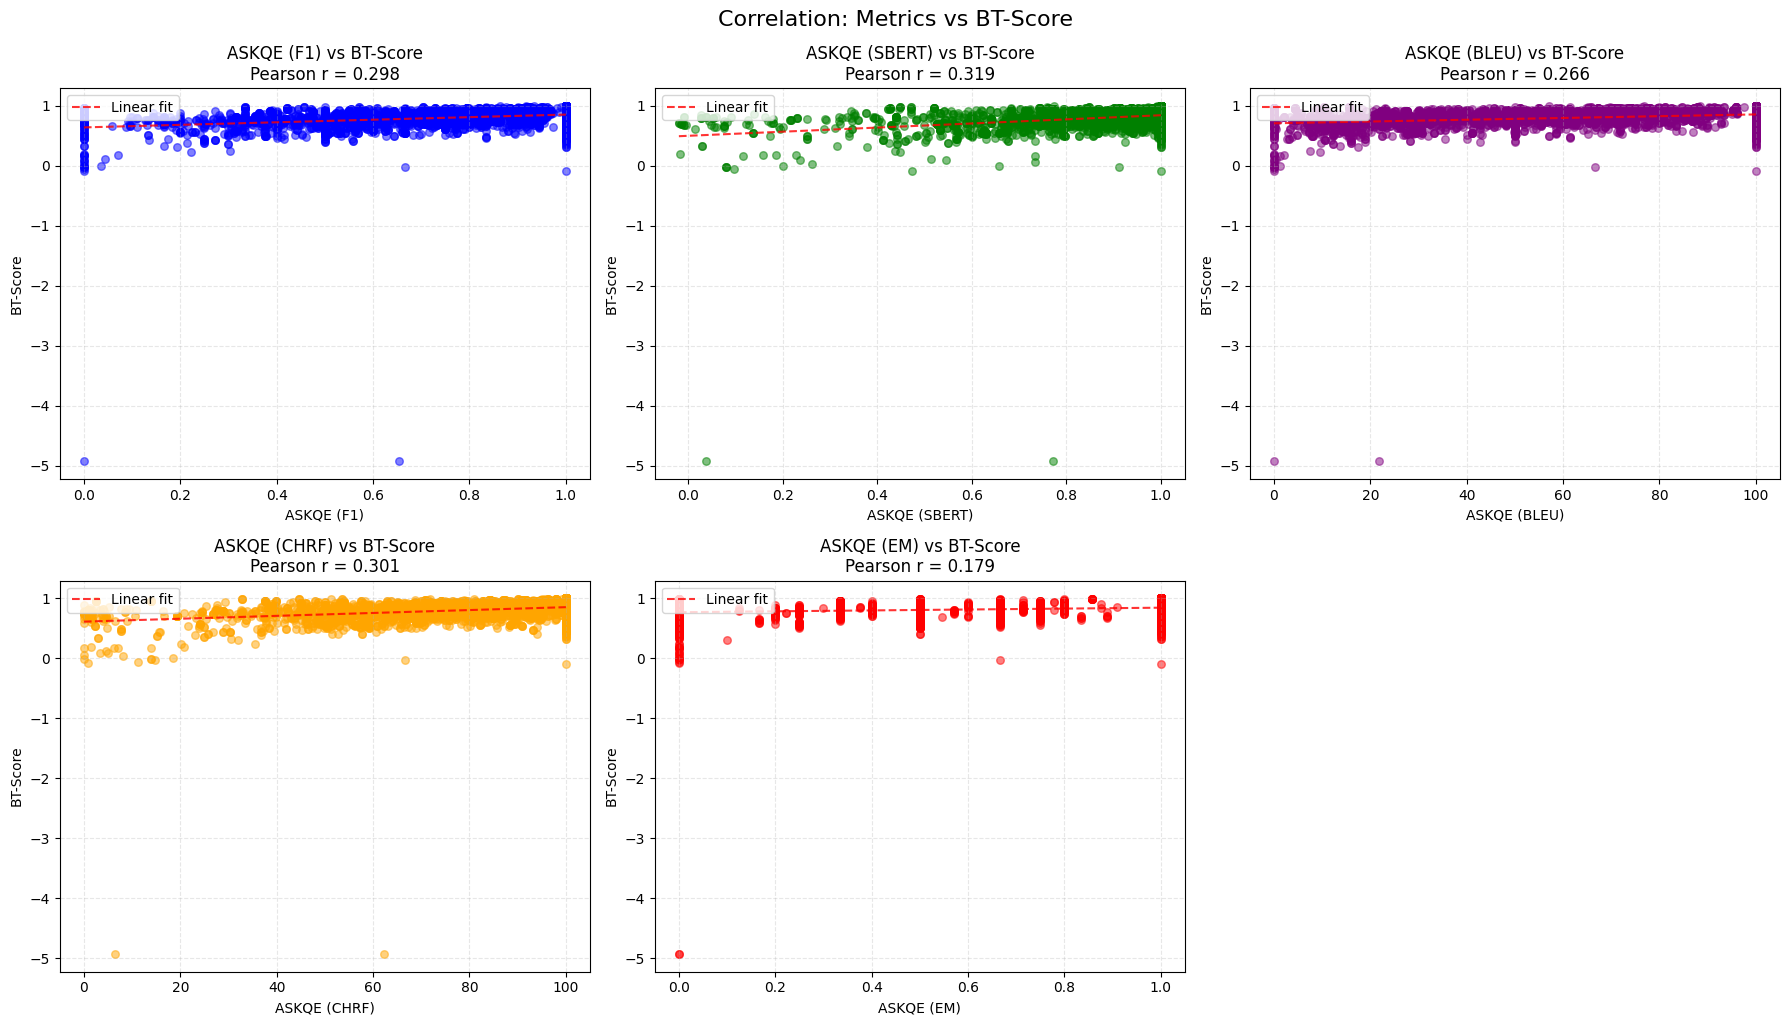

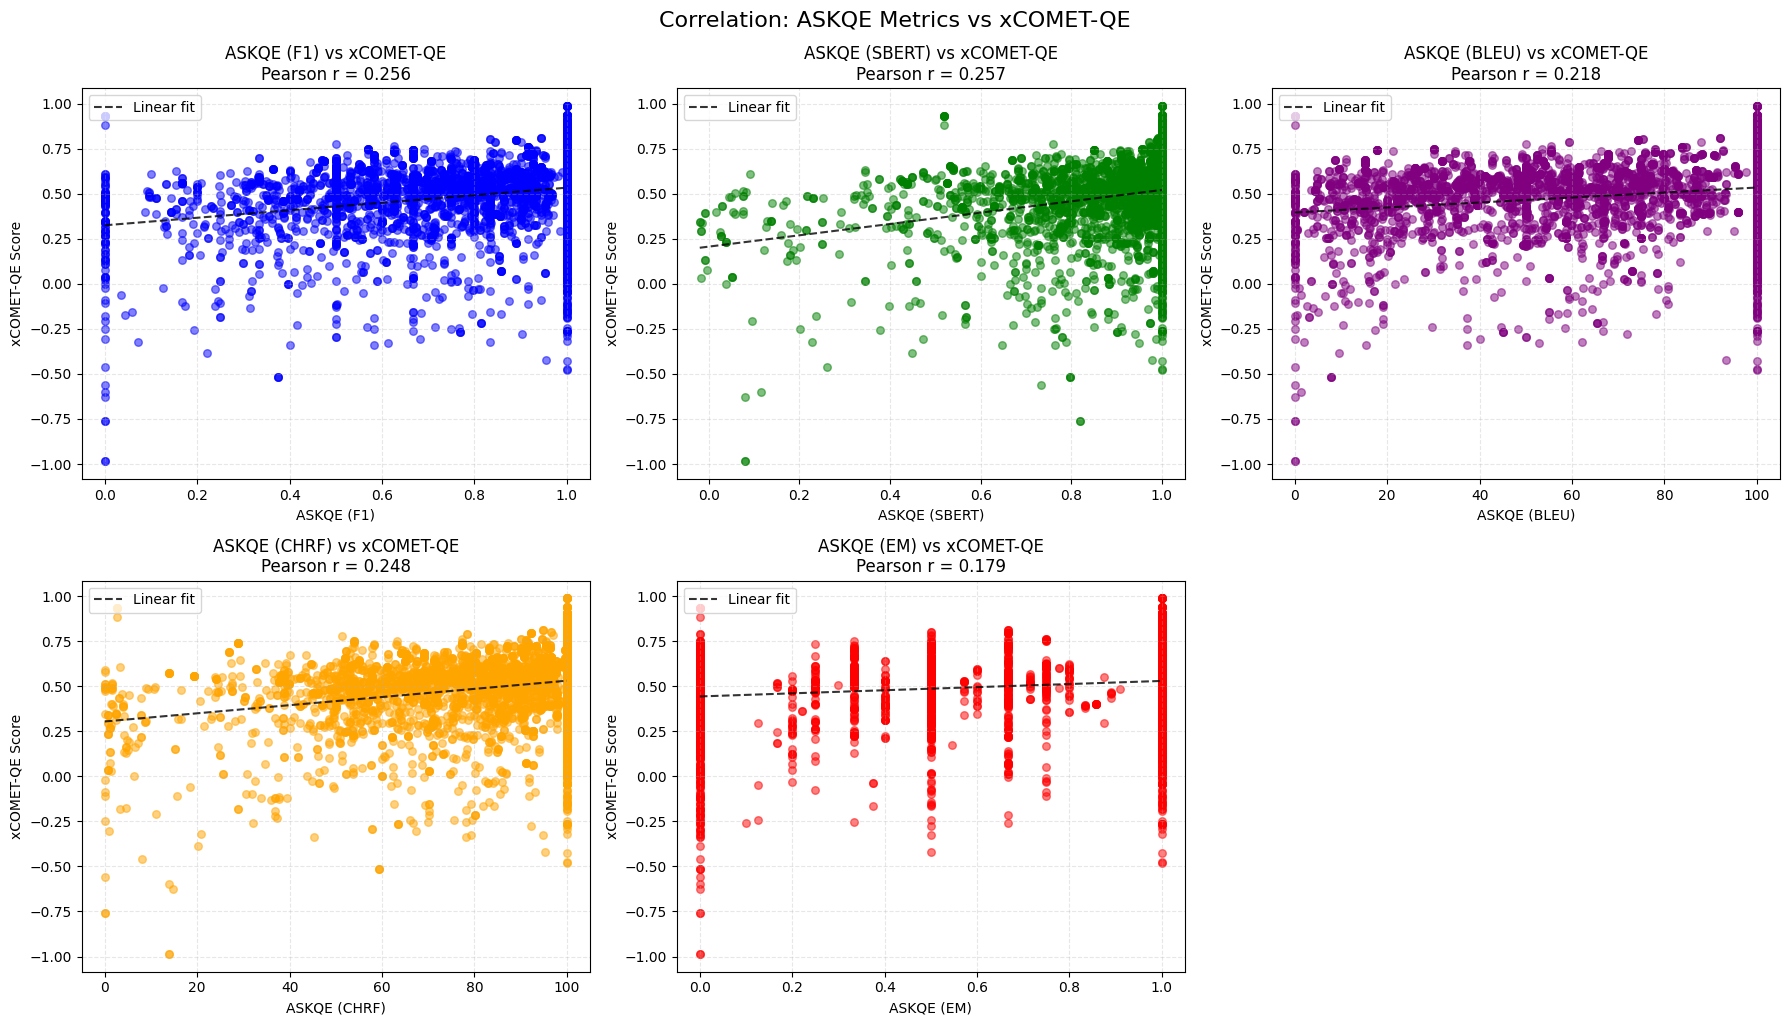

In [20]:
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


metrics_to_analyze = {
    'ASKQE (F1)':    'askqe_f1',
    'ASKQE (SBERT)': 'askqe_sbert',
    'ASKQE (BLEU)':  'askqe_bleu',
    'ASKQE (CHRF)':  'askqe_chrf',
    'ASKQE (EM)':    'askqe_em',
    'xCOMET-QE':     'xcomet_score'
}

plot_config = [
    ('ASKQE (F1)',    'askqe_f1',    'blue'),
    ('ASKQE (SBERT)', 'askqe_sbert', 'green'),
    ('ASKQE (BLEU)',  'askqe_bleu',  'purple'),
    ('ASKQE (CHRF)',  'askqe_chrf',  'orange'),
    ('ASKQE (EM)',    'askqe_em',    'red'),
    ('xCOMET-QE',     'xcomet_score','brown')
]

print("\n" + "="*60)
print("Pearson Correlation Analysis: Metrics vs BT-Score")
print("="*60)

for label, col in metrics_to_analyze.items():

    if col == 'xcomet_score':
        continue

    corr, p_val = pearsonr(df_results[col], df_results['bt_score'])
    sig = "Significant" if p_val < 0.05 else "Not Significant"

    print(f"\n{label} vs BT-Score:")
    print(f"  Pearson r = {corr:.4f}")
    print(f"  p-value   = {p_val:.4e} ({sig})")

plot_config_fig1 = [item for item in plot_config if item[1] != 'xcomet_score']

fig1, axes1 = plt.subplots(2, 3, figsize=(18, 10))
if isinstance(axes1, np.ndarray): axes1 = axes1.flatten()

for i, (label, col, color) in enumerate(plot_config_fig1):
    ax = axes1[i]

    x_data = df_results[col]

    ax.scatter(x_data, df_results['bt_score'], alpha=0.5, s=30, color=color)

    z = np.polyfit(df_results[col], df_results['bt_score'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df_results[col].min(), df_results[col].max(), 100)
    ax.plot(x_line, p(x_line), 'r--', alpha=0.8, label='Linear fit')

    corr, _ = pearsonr(df_results[col], df_results['bt_score'])
    ax.set_title(f'{label} vs BT-Score\nPearson r = {corr:.3f}')

    ax.set_xlabel(label)
    ax.set_ylabel('BT-Score')
    ax.legend(loc='upper left')
    ax.grid(True, linestyle='--', alpha=0.3)

for j in range(len(plot_config_fig1), len(axes1)):
    fig1.delaxes(axes1[j])

plt.tight_layout()
plt.suptitle('Correlation: Metrics vs BT-Score', y=1.02, fontsize=16)


print("\n" + "="*60)
print("Pearson Correlation Analysis: ASKQE Metrics vs xCOMET-QE")
print("="*60)

askqe_metrics_only = {k: v for k, v in metrics_to_analyze.items() if v != 'xcomet_score'}

for label, col in askqe_metrics_only.items():

    corr, p_val = pearsonr(df_results[col], df_results['xcomet_score'])

    sig = "Significant" if p_val < 0.05 else "Not Significant"
    print(f"\n{label} vs xCOMET-QE:")
    print(f"  Pearson r = {corr:.4f}")
    print(f"  p-value   = {p_val:.4e} ({sig})")

plot_config_fig2 = plot_config_fig1

fig2, axes2 = plt.subplots(2, 3, figsize=(18, 10))
if isinstance(axes2, np.ndarray): axes2 = axes2.flatten()

for i, (label, col, color) in enumerate(plot_config_fig2):
    ax = axes2[i]

    x_data = df_results[col]

    ax.scatter(x_data, df_results['xcomet_score'], alpha=0.5, s=30, color=color)

    z = np.polyfit(df_results[col], df_results['xcomet_score'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df_results[col].min(), df_results[col].max(), 100)
    ax.plot(x_line, p(x_line), 'k--', alpha=0.8, label='Linear fit')

    corr, _ = pearsonr(df_results[col], df_results['xcomet_score'])
    ax.set_title(f'{label} vs xCOMET-QE\nPearson r = {corr:.3f}')

    ax.set_xlabel(label)
    ax.set_ylabel('xCOMET-QE Score')
    ax.legend(loc='upper left')
    ax.grid(True, linestyle='--', alpha=0.3)

for j in range(len(plot_config_fig2), len(axes2)):
    fig2.delaxes(axes2[j])

plt.tight_layout()
plt.suptitle('Correlation: ASKQE Metrics vs xCOMET-QE', y=1.02, fontsize=16)

plt.show()

##GMM


--- GMM Decision Accuracy ---
F1: 45.63% (Acc μ: 1.000, Rej μ: 0.648)
BLEURT: 44.14% (Acc μ: 100.000, Rej μ: 47.791)
CHRF: 44.19% (Acc μ: 100.000, Rej μ: 70.778)
EM: 45.36% (Acc μ: 1.000, Rej μ: 0.235)
SBERT: 46.83% (Acc μ: 1.000, Rej μ: 0.828)
BERTScore: 77.05% (Acc μ: 0.819, Rej μ: 0.204)
COMET: 73.65% (Acc μ: 0.545, Rej μ: 0.235)


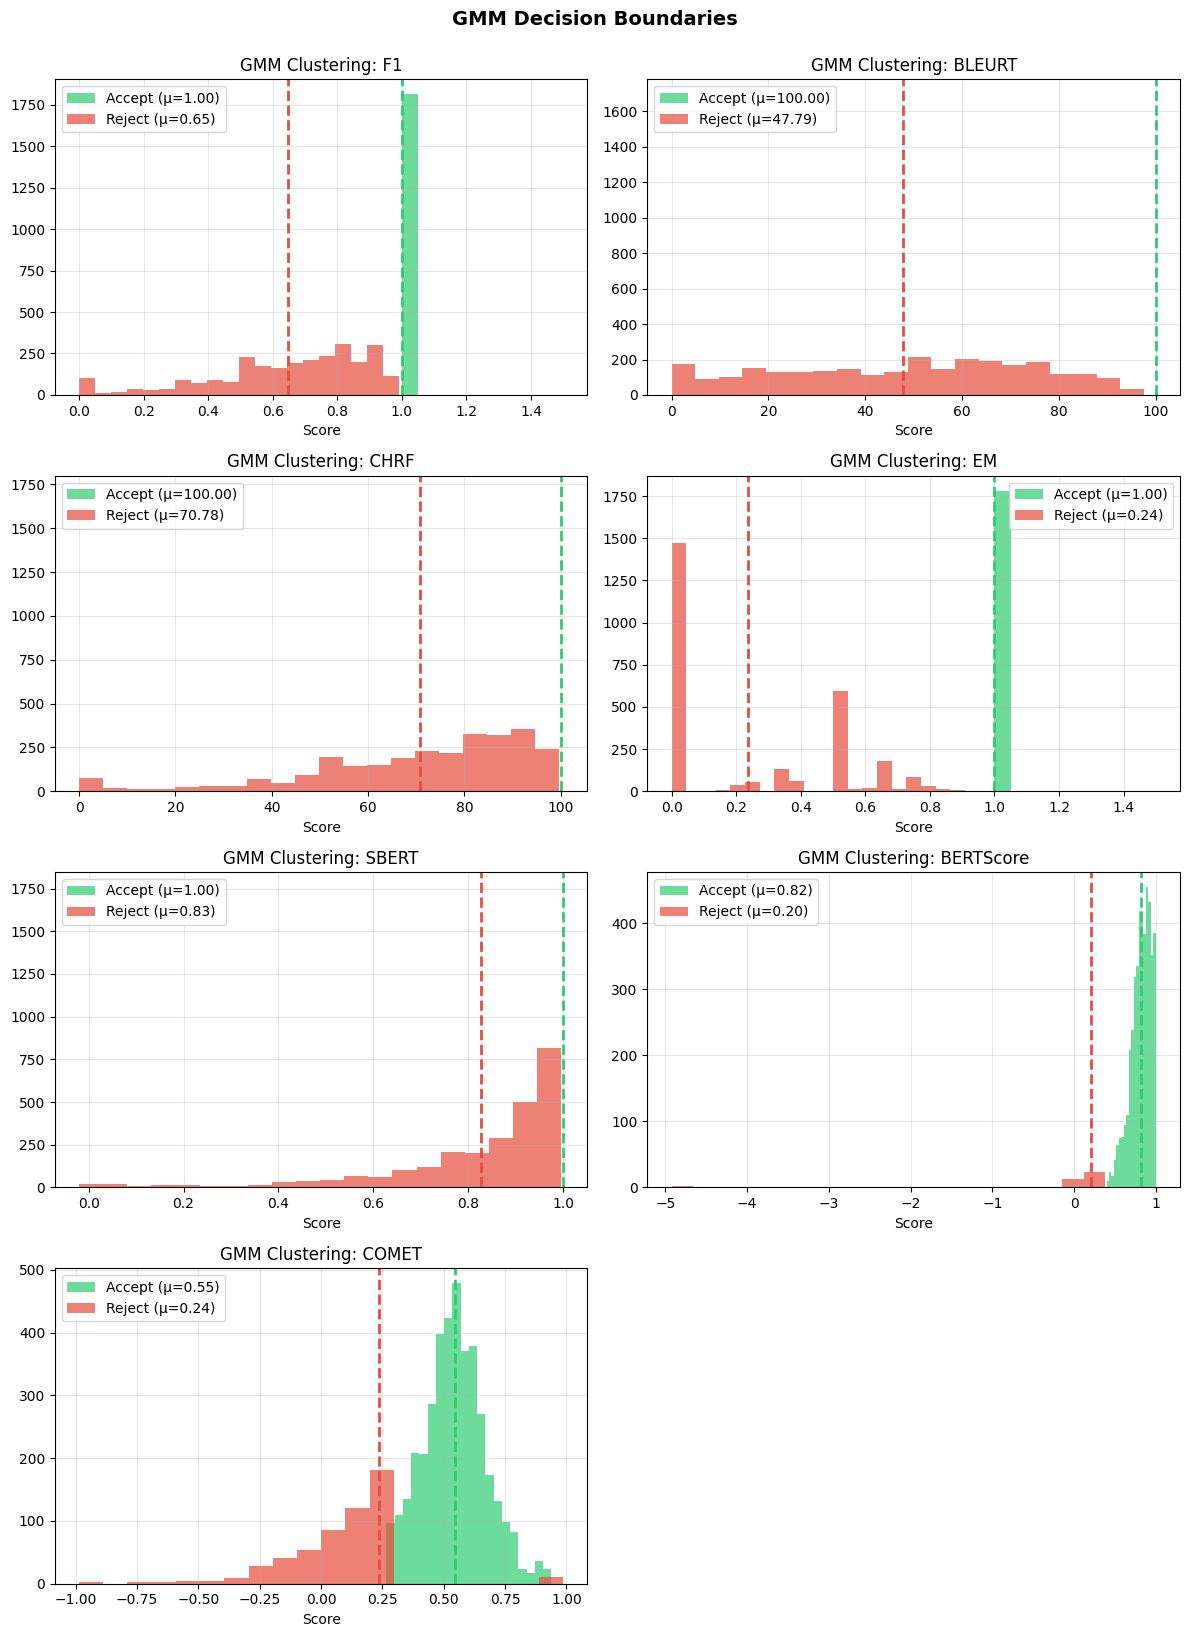

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

def get_human_labels(df):
    """Generates ground truth booleans (Accept=True) from severity strings."""
    valid_severities = {'no error', 'neutral', 'minor', 'none'}
    return df['severity'].astype(str).str.lower().isin(valid_severities)

def fit_gmm(data):
    """Fits a 2-component GMM and returns the model, means, and cluster assignments."""
    X = data.values.reshape(-1, 1)
    gmm = GaussianMixture(n_components=2, random_state=42).fit(X)

    means = gmm.means_.flatten()
    accept_idx = np.argmax(means)  # The cluster with higher score is "Accept"
    labels = gmm.predict(X)

    return means, accept_idx, labels

def evaluate_metric(df, col, name):
    """Calculates decision accuracy for a single metric."""

    # Get GMM predictions
    means, accept_idx, labels = fit_gmm(df[col])
    pred_accept = (labels == accept_idx)

    # Compare with ground truth
    human_accept = get_human_labels(df)
    accuracy = np.mean(pred_accept == human_accept) * 100

    print(f"{name}: {accuracy:.2f}% (Acc μ: {means[accept_idx]:.3f}, Rej μ: {means[1-accept_idx]:.3f})")
    return accuracy

def plot_clusters(df, metrics):
    """Visualizes GMM clusters for all valid metrics."""
    valid_metrics = [(c, n) for c, n in metrics if c in df.columns]

    n = len(valid_metrics)
    cols = 2
    rows = (n + 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
    axes = np.array(axes).flatten()

    for ax, (col, name) in zip(axes, valid_metrics):
        X = df[col].values

        means, accept_idx, labels = fit_gmm(df[col])
        reject_idx = 1 - accept_idx

        # Plot histograms for both clusters
        for idx, color, label in [(accept_idx, '#2ecc71', 'Accept'), (reject_idx, '#e74c3c', 'Reject')]:
            subset = X[labels == idx]
            ax.hist(subset, bins=20, alpha=0.7, color=color, label=f'{label} (μ={means[idx]:.2f})')
            ax.axvline(means[idx], color=color, linestyle='--', linewidth=2)

        ax.set_title(f'GMM Clustering: {name}')
        ax.set_xlabel('Score')
        ax.legend()
        ax.grid(alpha=0.3)

    # Clean up empty subplots
    for ax in axes[n:]: fig.delaxes(ax)

    plt.tight_layout()
    plt.suptitle('GMM Decision Boundaries', y=1.02, fontsize=14, fontweight='bold')
    plt.show()

metrics = [
    ('askqe_f1', 'F1'), ('askqe_bleu', 'BLEURT')
    ,('askqe_chrf', 'CHRF'), ('askqe_em', 'EM')
    ,('askqe_sbert', 'SBERT')
    ,('bt_score', 'BERTScore'), ('xcomet_score', 'COMET')
]

print("\n--- GMM Decision Accuracy ---")
results = {name: evaluate_metric(df_results, col, name) for col, name in metrics}

plot_clusters(df_results, metrics)